In [1]:
import torch ## gpu capable
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
# pulling the given data
train_df = pd.read_csv("mnist_train.csv")
test_df = pd.read_csv("mnist_test.csv")

# splitting features from labels. 
X_train = train_df.iloc[:,1:].values ## csv mai data 1 ke baad se hai
y_train = train_df.iloc[:,0].values

X_test = test_df.iloc[:,1:].values
y_test = test_df.iloc[:,0].values

# squishing pixel values down to a 0-1 range.   --> Normalization
# neurons learn better jab values are small.
X_train = X_train / 255.0
X_test = X_test / 255.0


# converting to PyTorch tensors so we can actually feed them into the model.
# using float32 for pixels and long for labels (standard for CrossEntropyLoss).
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


In [ ]:
# generate a random shuffle for the 784 pixels and keep it consistent
perm = torch.randperm(784)# fixed shuffle

# apply the shuffle to the pixel columns
X_train_scrambled = X_train[:, perm]
X_test_scrambled = X_test[:, perm]


In [ ]:
# wrapping the tensors into a Dataset object so PyTorch knows how to index them
train_scrambled = TensorDataset(X_train_scrambled, y_train)
test_scrambled = TensorDataset(X_test_scrambled, y_test)

# shuffling the training set so the model doesn't memorize the order of the images
train_loader_scrambled = DataLoader(train_scrambled, batch_size=64, shuffle=True)

# no need to shuffle the test set—we just need it for evaluation
test_loader_scrambled = DataLoader(test_scrambled, batch_size=64)


In [ ]:
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # input layer: taking the 784 flattened pixels down to 128 features
        self.fc1 = nn.Linear(784, 128)

        # adding some non-linearity so the model can learn complex patterns
        self.relu = nn.ReLU()

        # output layer: squash those 128 features into 10 scores (one for each digit)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # pass input through the first layer and kick in the activation
        x = self.relu(self.fc1(x))

        # pass input through the first layer and kick in the activation
        x = self.fc2(x)
        return x

## initialize the model FCNN
model = FCNN()


In [ ]:
# Standard choice for classification; handles the Softmax and Log-Loss in one go
criterion = nn.CrossEntropyLoss()#classification

# using Adam optimizer and setting lr to 0.001 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
epochs = 9

for epoch in range(epochs):
    total_loss = 0
    for images, labels in train_loader_scrambled:
        # clear out old gradients so they don't stack up from the last batch
        optimizer.zero_grad()

        # forward pass: get the model's current best guess
        outputs = model(images)

        # see how far off we are from the actual labels
        loss = criterion(outputs, labels)

        # backpropagation
        loss.backward()

        # update the weights based on the gradients
        optimizer.step()

        # track the loss so we can see if the model is actually learning
        total_loss += loss.item()

    # quick progress update after every full pass through the data
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 324.7601
Epoch 2, Loss: 151.4929
Epoch 3, Loss: 106.0701
Epoch 4, Loss: 80.2658
Epoch 5, Loss: 62.8515
Epoch 6, Loss: 50.7849
Epoch 7, Loss: 42.1856
Epoch 8, Loss: 35.1478
Epoch 9, Loss: 28.0844


In [ ]:
correct = 0
total = 0

with torch.no_grad(): ## obvio gradients band
    for images, labels in test_loader_scrambled:
        # get the raw scores from the model
        outputs = model(images)

        # the model outputs 10 scores; the highest score's index is our predicted digit
        _, predicted = torch.max(outputs,1)

        # keep track of the total number of images we've seen
        total += labels.size(0)

        # count how many times the prediction matched the actual label
        correct += (predicted == labels).sum().item()
        
## total ->10k
print("Test Accuracy:", 100 * correct / total, "%")


Test Accuracy: 97.59 %


In [ ]:
# pulling the raw weight matrix from the first linear layer and then converting this into numpy
weights = model.fc1.weight.data.numpy()

# dimension of that  weights
print(weights.shape)   # (128, 784)


(128, 784)


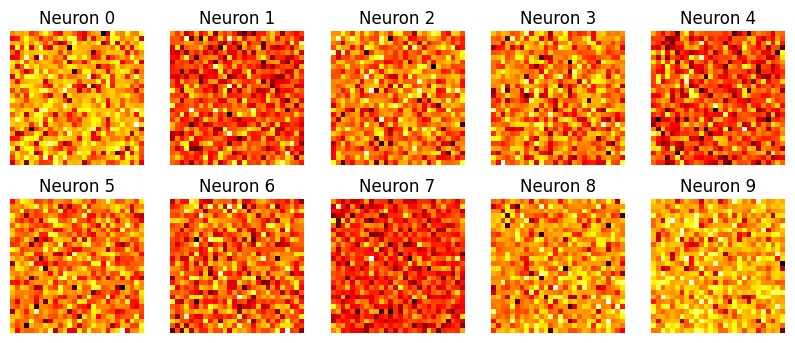

In [ ]:
# Setting up a 2x5 grid to peek at the first 10 neurons
fig, axes = plt.subplots(2,5, figsize=(10,4))

for i, ax in enumerate(axes.flat):
    # reshaping the weight vector back into a square to see the "spatial" pattern
    w = weights[i].reshape(28,28)

    # using 'hot' colormap to highlight high-intensity weights
    ax.imshow(w, cmap='hot')
    ax.axis('off')
    ax.set_title(f"Neuron {i}")

plt.show()
